# Homework 1: Information Retrieval
## Instructions
1. Students will form teams of three people each and submit a single homework for each team in the format - ID1_ID2_ID3.ipynb
2. Groups of three!
2. **Do not write your names anywhere.**
3. For the code part: 
> **Write your code only in the mentioned sections. Do not change the code of other sections**. Do not use any imports unless we say so.
4. For theoretical questions, if any - write your answer in the markdown cell dedicated to this task, in **English**.


#### Deviation from the aforementioned  instructions will lead to reduced grade
---


## Clarifications
1. The same score for the homework will be given to each member of the team.  
2. The goal of this homework is to test your understanding of the concepts presented in the lectures. \
Anyhow, we provide here detailed explanations for the code part and if you have problems - ask.
3. Questions can be sent to the forum, you are encouraged to ask questions but do so after you have been thinking about your question. 
4. The length of the empty gaps (where you are supposed to write your code) is a recommendation (the amount of space took us to write the solution) and writing longer code will not harm your grade. We do not expect you to use the programming tricks and hacks we used to make the code shorter.   
Having said that, we do encourage you to write good code and keep that in mind - **extreme** cases may be downgraded.  
We also encourage to use informative variable names - it is easier for us to check and for you to understand. 

For your convenience, , the code has a **DEBUG** mode that you may use in order to debug with toy data.  
It is recommended to solve the code in that mode (with efficiency in mind) and then run the code on all the data.
**Do not forget to file the HW with DEBUG == False**.


Since it is the first time we provide this homework please notify us if there is a bug/something is unclear, typo's exc..

5. We use Python 3.7 for programming.
6. Make sure you have all the packages and functions used in the import section. Most of it is native to Anaconda Python distribution.

### Have fun !

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline
from tqdm import tqdm
from typing import List,Dict
from IPython.display import Image
from IPython.core.display import HTML 
from pathlib import Path
import statistics
import math
import scipy.stats as st
import time

In [2]:
tic = time.perf_counter() #Start timer

In [3]:
from nltk.tokenize import word_tokenize 
from nltk.stem.porter import PorterStemmer
import nltk
nltk.download("stopwords")
nltk.download("punkt")
from string import punctuation, ascii_lowercase
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\omery\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\omery\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Debug
""" you can change this cell """

In [4]:
DEBUG = False
"""
Recommended to start with a small number to get a feeling for the preprocessing with prints (N_ROWS_FOR_DEBUG = 2)
later increase this number for 5*10**3 in order to see that the code runs at reasonable speed. 
When setting Debug == False, our code implements bow.fit() in 15-20 minutes according to the tqdm progress bar. Your solution is not supposed to be much further than that.
"""
N_ROWS_FOR_DEBUG = 5*10**3 

# Config

In [5]:
INPUT_FILE_PATH = Path("lyrics.csv")
BOW_PATH = Path("bow.csv")
N_ROWS = N_ROWS_FOR_DEBUG if DEBUG else None
CHUNCK_SIZE = 5 if DEBUG else 5*10**3
tqdm_n_iterations = N_ROWS//CHUNCK_SIZE +1 if DEBUG else 114*10**3//CHUNCK_SIZE + 1
COLS = [0]

## 1.1 Bag of words /TfIdf model
### Implement the following methods:

* `preprocess_sentence`: 
    * Lower case the word
    * Ignores it if it's in the stopwords list
    * Removes characters which are not in the allowed symbols
    * Stems it and appends it to the output sentence
    * Discards words with length <= 1
    
    
* `update_counts_and_probabilities`: 

    * Update self.unigram count (the amount of time each word is in the text)
    * Update self.bigram count (two consecutive word occurances)
    * Update inverted index: a dictionary with words as keys and the values is a dictionary - {'DocID' : word_count}   
    
* `compute_word_document_frequency`:

   * For each word count the number of docs it appears in. For example , for the word 'apple' -
$$\sum_{i \in docs} I(apple \in doc_i), I := Indicator function$$


* `update_inverted_index_with_tf_idf_and_compute_document_norm`:

    * Update the inverted index (which currently hold word counts) with tf idf weighing. We will compute tf by dividing with the number of words in each document. 
    * As we want to calculate the document norm, incrementally update the document norm. pay attention that later we apply sqrt to it to finish the process.

#### The result of this code is a bag of words model that already counts for TF-IDF weighing

In [6]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))
allowed_symbols = set(l for l in ascii_lowercase)

In [7]:
def preprocess_sentence(sentence : str) -> List[str]:
    output_sentence = []
    for word in word_tokenize(sentence):                           
        lower_word=word.lower()            # Lower case the word
        if lower_word not in stop_words:   # Ignores it if it's in the stopwords list
            word_letters = list(lower_word)
            valid_letters = []
            for l in word_letters:
                if l in allowed_symbols:
                    valid_letters.append(l)  # Removes characters which are not in the allowed symbols
            clean_word = ''.join(valid_letters)  # Reconnect the good letters back into one word
            clean_word = stemmer.stem(clean_word) # stem of the word
            if len(clean_word) > 1:             # Remove words that are 1 character long
                output_sentence.append(clean_word)
    return output_sentence    

def get_data_chuncks() -> List[str]:
    for i ,chunck in enumerate(pd.read_csv(INPUT_FILE_PATH, usecols = COLS, chunksize = CHUNCK_SIZE, nrows = N_ROWS)):
        chunck = chunck.values.tolist()
        yield [chunck[i][0] for i in range(len(chunck))]
        
class TfIdf:
    def __init__(self,  weighted_dic = None):
        self.weighted_dic = weighted_dic
        self.unigram_count =  Counter() # כל מילה כמה מופיעה בקורפוס
        self.bigram_count = Counter() # כל צמד מילים כמה פעמים מופיעות בקורפוס
        self.document_term_frequency = Counter() # כמות המילים שיש בכל שיר
        self.word_document_frequency = {} # כל מילה בקורפוס בכמה שירים היא מופיעה
        self.inverted_index = {}
        self.doc_norms = {}
        self.n_docs = -1
        self.sentence_preprocesser = preprocess_sentence
        self.bow_path = BOW_PATH

    def update_counts_and_probabilities(self, sentence, document_id):
        """
        Update the number of times a word appears in every document
        """
        sentence_len = len(sentence)
        self.document_term_frequency[document_id] = sentence_len
        for i,word in enumerate(sentence):
            self.unigram_count[word] += 1                                           #update the unigram Counter object that holds for each word how many time it appers in the corpus
            if i < (sentence_len - 1):                                              #edge condition to check that we are not in the last word
                bigram = word,sentence[i+1]                                         #take the word and the adjacent word in the sentence
                self.bigram_count[bigram] += 1                                        #update the bigram Counter object that holds for each pair of words how many time it appers in the corpus
            if word not in self.inverted_index:
                self.inverted_index[word] = {}
            if document_id not in self.inverted_index[word]:
                self.inverted_index[word][document_id] = 1
            else:
                self.inverted_index[word][document_id] += 1
            
    def fit(self):
        for chunck in tqdm(get_data_chuncks(), total = tqdm_n_iterations):
            for sentence in chunck: # sentence is a song (string)
                self.n_docs += 1 
                if not isinstance(sentence, str):
                    continue
                sentence = self.sentence_preprocesser(sentence)
                if sentence:
                    self.update_counts_and_probabilities(sentence,self.n_docs)
        self.save_bow() # bow is 'bag of words'
        self.compute_word_document_frequency()
        self.update_inverted_index_with_tf_idf_and_compute_document_norm()
             
    def compute_word_document_frequency(self):
        """
        Count the number of documents a specific words appears
        """
        for word in self.inverted_index.keys():
            self.word_document_frequency[word] = len(self.inverted_index[word])
            
    def update_inverted_index_with_tf_idf_and_compute_document_norm(self):
        for word in self.inverted_index.keys(): # For every word in the corpus
            for doc in self.inverted_index[word].keys():  # For every document containing the word
                n_words_in_doc = self.document_term_frequency[doc] # Length of the document is the number of words in it
                tf = (self.inverted_index[word][doc]) / n_words_in_doc  # Term frequency is the number of words in a docuemt divided by the number of the words in it
                idf = np.log10((self.n_docs + 1) / self.word_document_frequency[word])
                w_ij = tf * idf # Calcluated tf-idf metric              
                self.inverted_index[word][doc] = w_ij # Set the weight of a document to the tf-idf metric value   
                if doc not in self.doc_norms:
                    self.doc_norms[doc] = 0  # initialize value for the first time that creating the doc norm
                self.doc_norms[doc] += (w_ij ** 2) # To calculate the norm, sum the square of the weights 
        for doc in self.doc_norms.keys():
            self.doc_norms[doc] = np.sqrt(self.doc_norms[doc]) # The norm of the document is the square root of the weights' sum of squares
            
    def save_bow(self):
        pd.DataFrame([self.inverted_index]).T.to_csv(self.bow_path)
                
tf_idf = TfIdf()
tf_idf.fit()

100%|██████████| 23/23 [15:32<00:00, 40.55s/it]


## 1.11 Bag of words model:

1. What is the computational complexity of this model, as a function of the number of docs in the corpus?
2. How can we make this code better in terms running time (parallelization or other topics you find)? 

## 1.2 DocumentRetriever
Not this retriever &#8595;


![dsafdsafsdafdsf](https://cdn3-www.dogtime.com/assets/uploads/2019/10/golden-cocker-retriever-mixed-dog-breed-pictures-cover-1.jpg)

### Implement the following methods:

`reduce_query_to_counts`: given a list of words returns a counter object with words as keys and counts as values.

`rank`: given a query and relevant documents calculate the similarity (cosine or inner product simialrity) between each document and the query.   
Make sure to transform the query word counts to tf idf as well. 

`sort_and_retrieve_k_best`: returns the top k documents.

In [8]:
class DocumentRetriever:
    def __init__(self, tf_idf):
        self.sentence_preprocesser = preprocess_sentence  
        self.vocab = set(tf_idf.unigram_count.keys())
        self.n_docs = tf_idf.n_docs
        self.inverted_index = tf_idf.inverted_index
        self.word_document_frequency = tf_idf.word_document_frequency
        self.doc_norms = tf_idf.doc_norms
        
    def rank(self,query: Dict[str,int], documents: Dict[str,Counter], metric: str ) -> Dict[str, float]:
        result = {} # key: DocID , value : float , simmilarity to query
        query_len = np.sum(np.array(list(query.values())))
        tfidf_sum_sqrt = 0 # initialize the query norm
        query_tfidf = {} # initialize dict that holds the query words and their tf-idf weighting 
        for word in query:
            tf = query[word] / query_len              #term frequency of the word is the number of times that the word appers in the query divided in the number of words in the query
            idf = np.log10((self.n_docs+1)/self.word_document_frequency[word]) #calcluated tf idf weighting: term frequency double in idf(log 10 of the number of docs, divded in the number of docs that the word appers in )
            query_tfidf[word] = tf * idf
            tfidf_sum_sqrt += (query_tfidf[word]) ** 2        #in order to calculated the norm, we will sum up the square weights and in the end take the sqrt 
            for doc in documents[word]:    #for each doc from the docs that the word appears in
                if doc not in result:             #first time the doc appears in the final dict result
                    result[doc] = 0                 #initialize the doc value to zero
                result[doc] += (documents[word][doc] * query_tfidf[word]) #sum up the inner_product calculation to the result dict (word-dict weighting duble the word-query weighting)      
        query_norm = np.sqrt(tfidf_sum_sqrt)
        if metric == 'cosine':
            for doc in result:
                result[doc] = result[doc] / (query_norm * self.doc_norms[doc])   #doc_norms is already sqrt fron Q.1.1
        return result
        
    def sort_and_retrieve_k_best(self, scores: Dict[str, float],k :int):
        return list(dict(Counter(scores).most_common(k)).keys())
  
    def reduce_query_to_counts(self, query : List)->  Counter:
        return Counter(query)

    def get_top_k_documents(self,query : str, metric: str , k = 5) -> List[str]:
        query = self.sentence_preprocesser(query)
        query = [word for word in query if word in self.vocab] # filter nan 
        query_bow = self.reduce_query_to_counts(query)
        relavant_documents = {word : self.inverted_index.get(word) for word in query}
        ducuments_with_similarity = self.rank(query_bow,relavant_documents, metric)
        return self.sort_and_retrieve_k_best(ducuments_with_similarity,k)
        
dr = DocumentRetriever(tf_idf)

In [9]:
from IPython.display import HTML
query = "Better stop dreaming of the quiet life, 'cause it's the one we'll never know And quit running for that runaway bus 'cause those rosy days are few And stop apologizing for the things you've never done 'Cause time is short and life is cruel but it's up to us to change This town called malice"
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/KT6ZtUbVw1M?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

C:\Users\omery\anaconda3\lib\site-packages\IPython\core\display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [10]:
cosine_top_k = dr.get_top_k_documents(query, 'cosine')
print(cosine_top_k)
inner_product_top_k = dr.get_top_k_documents(query, 'inner_product')
print(inner_product_top_k)

[50221, 50233, 28634, 101537, 38867]
[111535, 111650, 26464, 38867, 7344]


In [11]:
for index, song in enumerate(pd.read_csv(INPUT_FILE_PATH,usecols = [0]).iloc[cosine_top_k]['Lyric']):
    sep = "#"*50
    print(F"{sep}\nsong #{index} \n{song} \n{sep}")

##################################################
song #0 
A Town Called Malice. Better stop dreaming of the quiet life. 'Cos it's the one we'll never know. And quit running for that runaway bus. 'Cos those rosey days are few. And stop apologising for the things you've never done,. 'Cos time is short and life is cruel. Well it's up to us to change. This town called malice uh uh yeah. Rows and rows of disused milk floats. stand dying in the dairy yard. And a hundred lonely housewives clutch empty milk. bottles to their hearts. Hanging out their old love letters on the line to dry. It's enough to make you stop believing when tears come. fast and furious. In a town called malice uh uh yeah. Struggle after struggle. Year after year. The atmosphere's a fine blend of ice. I'm almost stone cold dead. In a town called malice uh uh yeah. A whole street's belief in Sunday's roast beef. gets dashed against the Co-op. To either cut down on beer or the kids new gear. It's a big decision in a town 

# 1.3 term statistics:
Use "tf_idf" object that we created earlier and answer the following questions:

1. How many unique words we have?
2. How many potential word bigrams we have? How many actual word bigrams we have? How do you explain this difference?
3. What is the storage size of the input file "lyrics.csv"? What is the output file (bow.csv) size? how do you explain this difference?  

In [12]:
# 1. 
print ('The number of unique words is: ',len(tf_idf.inverted_index))

"""
When we initilize the inverted index we entered each word ones to the dictionary 
and just update the number of the occurance, Therfore all the words there are unique.
In addition we could do that with the 'bow' object like that:
data=pd.read_csv('bow.csv')
df1=pd.DataFrame(data)
print ('Number of unique words is: ',df1.shape[0])
"""

# 2.
print ('Potenial word bigrams (worst case) is: ',((len(tf_idf.inverted_index))**2))
print ('Actual word bigrams is: ',(len(tf_idf.bigram_count)))

"""
We'll compare the actual word biagrmas, which have only unique pairs combinations to the potential word biagram.
Therfore, we want only the number of the unique pairs combinations. If we have V unique words in all of the corpus,
we can say that the count of the potential word bigrams is V**2- This is the upper barrier.
However, in the given data set, the number of pairs combinations is lower than this upper barrier, 
as there are repetitive word pairs combinations in the corpus.
If we are talking not about the unique pairs cpombinations,so for one document we can get n-1 pairs combinations,
when n is the number of all the words in the documents (not only the unique number of words).
Therefore, for D documents we can get (n-1)*D pairs combinations (not unique).
"""

# 3.
print ('The storage size of bow.csv is: ',BOW_PATH.stat().st_size, ' Bytes')
print ('The storage size of lyrcis.csv is: ',INPUT_FILE_PATH.stat().st_size, ' Bytes')

"""
The lyrcis.csv has the full amount of words in the corpus, that includes words that appears more than once.
However, the bow.csv contain each word, that appears more than once in the corpus, only once (with the number of occurrences).
"""

The number of unique words is:  105761
Potenial word bigrams (worst case) is:  11185389121
Actual word bigrams is:  2605158
The storage size of bow.csv is:  85957502  Bytes
The storage size of lyrcis.csv is:  168274338  Bytes


'\nThe lyrcis.csv has the full amount of words in the corpus, that includes words that appears more than once.\nHowever, the bow.csv contain each word, that appears more than once in the corpus, only once (with the number of occurrences).\n'

## 1.4 NgramSpellingCorrector
Now we will implement a Ngarm (character Ngrams) spelling corrector. That is, we have an out of vocabulary word (v) and we want to retrieve the most similar words (in our vocabulary) to this word.
we will model the similarity of two words by-

$$sim(v,w) := prior \cdot likelihood = p(w) \cdot P(v|w) $$ 
$$P(v|w) := JaccardIndex =  \frac{|X \cap Y|}{|X \cup Y|}$$

Where v is an out of vocabulary word (typo or spelling mistake), w is in a vocabulary word, X is the ngram set of v and Y is the ngram set of w.
For example, if n == 3, the set of ngrams for word "banana" is set("ban","ana","nan","ana") = {"ban","ana","nan"}

In order to do it efficently, we will first construct an index from the possible Ngrams we have seen in our corpus to the words that those Ngrams appear in, in order prevent comparing v to all of the words in our corpus.
Then, we will implement a function that computes this similarity.

* Make sure you compute the JaccardIndex efficently!

In [13]:
def get_bigrams(word):
    for ngram in nltk.ngrams(word, 2):
        yield "".join(list(ngram))
    
"""
for example - get_bigrams is a generator, which is an object we can loop on:
for ngram in get_bigrams(word):
    DO SOMETHING
"""

'\nfor example - get_bigrams is a generator, which is an object we can loop on:\nfor ngram in get_bigrams(word):\n    DO SOMETHING\n'

In [14]:
class NgramSpellingCorrector:
    def __init__(self, unigram_counts: Counter, get_n_gram: callable):
        self.unigram_counts = unigram_counts
        self.ngram_index = {}
        self.get_n_grams = get_n_gram
    
    def build_index(self) -> None:
        for word in self.unigram_counts.keys():                  # Goes all over the word in the unigram
            word_ngrams_set=set(self.get_n_grams(word))               # Split the word by the get_n_gram which choosen, and turn it to set, which remove duplicate
            for ngram in word_ngrams_set:                             # Go all over the ngram we got from the splitting
                if ngram not in self.ngram_index:                # If ngram not yed appended to the dictionary ngram_index
                    self.ngram_index[ngram]=[]                   # Initilize the value of this ngram as empty list
                self.ngram_index[ngram].append(word)             # For each ngram key, append to the value the word which certainly contains this ngrm
      
    def get_top_k_words(self,word:str,k=5) -> (List[str], Dict[str, float]):
        probabilties={}                                             # Initilize dictionary which contains the probabilty-sim for each word
        word_ngrams_set=set(self.get_n_grams(word))                    # Split the big string by the n_gram which, and turn it to set, which remove duplicate
        for ngram in word_ngrams_set:                                  # Goes over each ngram in the whole word
            if ngram in self.ngram_index:                        # If ngram not in dictionary, it will continue
                for word in self.ngram_index[ngram]:               # Goes over each word that contain this ngram
                    if word not in probabilties:
                        split_word=set(self.get_n_grams(word))     # Split this word by the n_gram which, and turn it to set, which remove duplicate
                        intersection = len(list(set(word_ngrams_set).intersection(split_word)))          # Got the number of ngram that are in both the word and the big string
                        union = (len(word_ngrams_set) + len(split_word)) - intersection              # Got the number of ngram that are in the word and in the big string
                        similarity=(float(intersection)/union)
                        probabilties[word]=similarity                        # Append the sim to the dictionary under the word (the key)
        return (list(dict(Counter(probabilties).most_common(k)).keys()) , probabilties)                  # Return only the top K words, that for them the sim is biggest

class BigramSpellingCorrector(NgramSpellingCorrector):
    def __init__(self, unigram_counts: Counter):
        super().__init__(unigram_counts, get_bigrams)

In [15]:
out_of_vocab_word = 'acress'
bigram_spelling_corrector = BigramSpellingCorrector(tf_idf.unigram_count)
bigram_spelling_corrector.build_index()
candidate_words, scores = bigram_spelling_corrector.get_top_k_words(out_of_vocab_word)

In [16]:
candidate_words

['cress', 'recress', 'ress', 'actress', 'cresson']

In [17]:
for word in candidate_words:
    print(f'The jaccared score for the word {word} is {round(scores[word],2)}')

The jaccared score for the word cress is 0.8
The jaccared score for the word recress is 0.67
The jaccared score for the word ress is 0.6
The jaccared score for the word actress is 0.57
The jaccared score for the word cresson is 0.57


## 1.5 Zipf's law 
For this part of the assignment, you will not ignore the “stop words” in advance, but rather take a data-driven approach. you will first create a dictionary with keys representing the words in the corpus and values representing how many times each word appears.

Using a simple visualization (scatter plot), you will then check whether the frequency of the words corresponds to Zipf's law.  Once we see that this is indeed the case, we'll try to display the graph on a logarithmic scale (both x and y axis) and see if we can get a linear trend.

Each word should then weighted according to its frequency, so that the words that appear most often are given a lower weight, and so on for the words whose frequency is the lowest.

So how we are going to do that?
You will standardize all the frequency values in the dictionary and after that, they will be re-weighted. If the value of the word is less than zero after standardization, you will calculate P(X <=Z) and if the value of the word is greater than 0, you will calculate 1 - P (X <= Z), and this will be the weight for every word.

Now you will multiply the standard “tf” calculation we made at the beginning of the assignment by another coefficient, which is the weight we just calculated.

Lastly, we will perform the same query you performed in the previous part of the assignment and check if the returned documents are identical or different.


In [18]:
#Override preprocess_sentence function in such a way that stop words are not ignored
def preprocess_sentence(sentence : str) -> List[str]:
    output_sentence = []
    for word in word_tokenize(sentence):
        lower_word=word.lower()            # Lower case the word
        word_letters = list(lower_word)
        valid_letters = []
        for l in word_letters:
            if l in allowed_symbols:
                valid_letters.append(l)  # Removes characters which are not in the allowed symbols
        clean_word = ''.join(valid_letters)  # Reconnect the good letters back into one word
        clean_word = stemmer.stem(clean_word) # stem of the word
        if len(clean_word) > 1:             # Remove words that are 1 character long
            output_sentence.append(clean_word)
    return output_sentence

In [19]:
tf_idf_2 = TfIdf()
tf_idf_2.fit()

100%|██████████| 23/23 [33:05<00:00, 86.34s/it] 


In [20]:
totalFrequency = tf_idf_2.unigram_count

def find_k_most_frequant_words(k : int, totalFrequency: Dict[str,int]) -> Dict[str,int]:
    top_k_frequant_words = dict(Counter(totalFrequency).most_common(k))
    return top_k_frequant_words

top_5_frequant_words = find_k_most_frequant_words(5, totalFrequency)

In [21]:
print(top_5_frequant_words)

{'you': 1343235, 'the': 1178419, 'to': 689489, 'and': 674981, 'it': 667416}


### Plot Word Frequency - scatterplot

<function matplotlib.pyplot.show(close=None, block=None)>

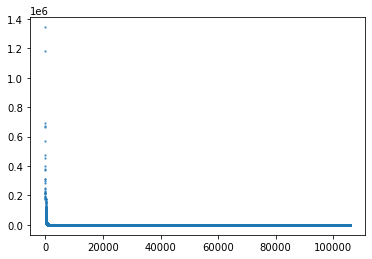

In [22]:
word_id = range(1, len(totalFrequency)+1)
frequency_values = sorted(totalFrequency.values(), reverse=True)

plt.scatter(word_id, frequency_values, s=2, alpha=0.6)
plt.show

In [23]:
#Does the plot follow Zips' law?

"""
### Your verbal solution here

### End your verbal solution here
"""

'\n### Your verbal solution here\n\n### End your verbal solution here\n'

### Plot Word Frequency - scatterplot - log scale

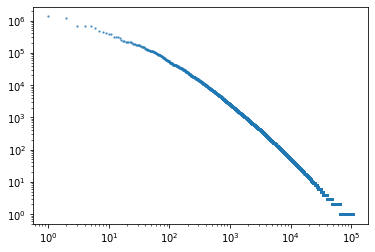

In [24]:
fig, ax = plt.subplots(figsize = (6, 4))
ax.scatter(word_id, frequency_values, s=2, alpha=0.6)

ax.set_xscale("log")
ax.set_yscale("log")

### Data standartization and reweightening

#### Standartization# 

In [25]:
mean = statistics.mean(frequency_values)
std =math.sqrt(statistics.variance(frequency_values))

In [26]:
def standartization(totalFrequency, mean, std) -> Dict[str, int]:
    standardized_dic = {}
    for word in totalFrequency:
        standardized_dic[word] = (totalFrequency[word] - mean) / std
    return standardized_dic

standardized_dic = standartization(totalFrequency, mean, std)

In [27]:
# a={'a':5,'d':6.3,'g':9}
# mean = statistics.mean(a.values())
# std =math.sqrt(statistics.variance(a.values()))

# standardized_dic = standartization(a, mean, std)

# print(statistics.mean(standardized_dic.values()))
# print(math.sqrt(statistics.variance(standardized_dic.values())))

# math.sqrt(statistics.variance(sorted(standardized_dic.values(), reverse=True)))

In [28]:
def calc_probability_of_zscore(standardized_dic) -> Dict[str,int]:
    wighted_dic = {}
    for key in standardized_dic.keys():
        if  standardized_dic[key] <= 0:
            wighted_dic[key] = st.norm(0, 1).cdf(standardized_dic[key])
        else:
            wighted_dic[key] = 1 - st.norm(0, 1).cdf(standardized_dic[key])
    return wighted_dic

weighted_dic = calc_probability_of_zscore(standardized_dic)

In [29]:
#Override the function update_inverted_index_with_tf_idf_and_compute_document_norm in such a way that you multiply the original tf by the weight of the word
class WeightedTfIdf(TfIdf):
    def update_inverted_index_with_tf_idf_and_compute_document_norm(self):
        for word in self.inverted_index.keys(): # For every word in the corpus
            for doc in self.inverted_index[word].keys():  # For every document containing the word
                n_words_in_doc = self.document_term_frequency[doc] # Length of the document is the number of words in it
                tf = (self.inverted_index[word][doc]) / n_words_in_doc  # Term frequency is the number of words in a docuemt divided by the number of the words in it
                idf = np.log10((self.n_docs + 1) / self.word_document_frequency[word])
                w_ij = tf * idf * weighted_dic[word] # Calcluated tf-idf metric              
                self.inverted_index[word][doc] = w_ij # Set the weight of a document to the tf-idf metric value   
                if doc not in self.doc_norms:
                    self.doc_norms[doc] = 0  # initialize value for the first time that creating the doc norm
                self.doc_norms[doc] += (w_ij ** 2) # To calculate the norm, sum the square of the weights 
        for doc in self.doc_norms.keys():
            self.doc_norms[doc] = np.sqrt(self.doc_norms[doc]) # The norm of the document is the square root of the weights' sum of squares 

In [30]:
weightedTfIdf = WeightedTfIdf(weighted_dic)
weightedTfIdf.fit()

 30%|███       | 7/23 [2:46:11<6:19:51, 1424.45s/it] 


KeyboardInterrupt: 

In [ ]:
weighted_dr = DocumentRetriever(weightedTfIdf)

In [ ]:
query = "Better stop dreaming of the quiet life, 'cause it's the one we'll never know And quit running for that runaway bus 'cause those rosy days are few And stop apologizing for the things you've never done 'Cause time is short and life is cruel but it's up to us to change This town called malice"

In [ ]:
cosine_top_k = weighted_dr.get_top_k_documents(query, 'cosine')
print(cosine_top_k)
inner_product_top_k = weighted_dr.get_top_k_documents(query, 'inner_product')
print(inner_product_top_k)

In [ ]:
#Is there any similarity between the documents retrieved? Please explain.

"""
### Your verbal solution here





### End your verbal solution here
"""

# 1.6 bigram's language model

#### Following on from section 1.4, this section discusses spelling corrections.
#### Documents were requested for the following query:

"the bad acress played role on the show"

#### It can be seen from section 1.4 that acress does not appear in the corpus and also received  five candidate words that could be considered its replacement. As soon as the sentence is given, it is possible and even desirable to consider the context in order to determine what candidate word to use. To do so, we will use bigram's language model to calculate P(w). Finally, we return the word with the best weighted score by multiplying P(w) by the jaccard index of the word. After you've done that, discuss the results.

#### Notice: only p(w) is calculated in this case using the bigram language model a. You dont need to calculate p(x|w).

In [ ]:
the_uncorrect_sentense = "the bad acress played role on the show"

#continue from here
#use tf_idf object from section 1.1!!
sentence = tf_idf.sentence_preprocesser(the_uncorrect_sentense)
dict_scores = {}
for i,word in enumerate(sentence):
    if word not in tf_idf.unigram_count:
        if i < len(sentence) - 1:
            next_word = sentence[i+1]
        else:
            next_word = None
        if i > 0:
            previous_word = sentence[i-1]
        else:
            previous_word = None
        candidate_words, scores = bigram_spelling_corrector.get_top_k_words(word)
        for fixed_word in candidate_words:
            if next_word:
                next_prob = tf_idf.bigram_count[(fixed_word,next_word)] / tf_idf.unigram_count[fixed_word]
            else:
                next_prob = 1
            if previous_word:
                previous_prob = tf_idf.bigram_count[(previous_word,fixed_word)] / tf_idf.unigram_count[previous_word]
            else:
                previous_prob = 1
            score = next_prob * previous_prob * scores[fixed_word]
            dict_scores[fixed_word] = score
        print(f'The new chosen word for the unidentified word *{word}* is {Counter(dict_scores).most_common(1)[0][0]}')    


# The End - You did it!

In [ ]:
#The time it took to run the entire code
toc = time.perf_counter()
print(f"The time it took to run the entire code is: {(toc - tic)/60} minuts")